# Hospital Length of Stay Prediction Analysis

# 1. Data Preparation and Preprocessing

In [0]:
# Load the tables directly from the default database
core_data = spark.table("default.kid_2016_core_exracted_3_csv")
hospital_data = spark.table("default.kids_2016_hospital_extracted_3_csv")
severity_data = spark.table("default.kid_2016_severity_extracted_2_csv")


**Merging these datasets**

In [0]:
hospital_data = hospital_data.drop("HOSP_REGION", "YEAR","KID_STRATUM")
severity_data=severity_data.drop("HOSP_KID")
merged_data = (
    core_data
    .join(severity_data, on="RECNUM", how="inner")  
    .join(hospital_data, on="HOSP_KID", how="inner")  
)

## Data Cleaning

**Changing datatype and removing unsignificant variables**

In [0]:
[(col, dtype) for col, dtype in merged_data.dtypes]

[('HOSP_KID', 'int'),
 ('RECNUM', 'int'),
 ('AGE', 'int'),
 ('AGE_NEONATE', 'int'),
 ('AMONTH', 'int'),
 ('AWEEKEND', 'int'),
 ('DIED', 'int'),
 ('DISCWT', 'int'),
 ('DISPUNIFORM', 'int'),
 ('DQTR', 'int'),
 ('DRG', 'int'),
 ('DRGVER', 'int'),
 ('DRG_NoPOA', 'int'),
 ('DXVER', 'int'),
 ('ELECTIVE', 'int'),
 ('FEMALE', 'int'),
 ('HCUP_ED', 'int'),
 ('HOSP_REGION', 'int'),
 ('I10_DX1', 'string'),
 ('I10_DX2', 'string'),
 ('I10_DX3', 'string'),
 ('I10_DX4', 'string'),
 ('I10_DX5', 'string'),
 ('I10_DX6', 'string'),
 ('I10_DX7', 'string'),
 ('I10_DX8', 'string'),
 ('I10_DX9', 'string'),
 ('I10_DX10', 'string'),
 ('I10_DX11', 'string'),
 ('I10_DX12', 'string'),
 ('I10_DX13', 'string'),
 ('I10_DX14', 'string'),
 ('I10_DX15', 'string'),
 ('I10_DX16', 'string'),
 ('I10_DX17', 'string'),
 ('I10_DX18', 'string'),
 ('I10_DX19', 'string'),
 ('I10_DX20', 'string'),
 ('I10_DX21', 'string'),
 ('I10_DX22', 'string'),
 ('I10_DX23', 'string'),
 ('I10_DX24', 'string'),
 ('I10_DX25', 'string'),
 ('I10_DX2

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

merged_data = merged_data.withColumn("KID_STRATUM", col("KID_STRATUM").cast(IntegerType()))
merged_data = merged_data.withColumn("PAY1", col("PAY1").cast(IntegerType()))
merged_data = merged_data.withColumn("PL_NCHS", col("PL_NCHS").cast(IntegerType()))
merged_data = merged_data.withColumn("LOS", col("LOS").cast(IntegerType()))

# Show the result to verify the changes
merged_data.show()

+--------+--------+---+-----------+------+--------+----+------+-----------+----+---+------+---------+-----+--------+------+-------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+------------+-------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+-----------+-----------+---+---+---------+----+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-----+----+------+-------+--------+----+-----------+------+---------------------+---------------+------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+


**Droping insignificant variables**

In [0]:


# Drop columns I10_PR1 to I10_PR15
merged_data = merged_data.drop(*[f'I10_PR{i}' for i in range(1, 16)])

# Drop columns PRDAY1 to PRDAY15
merged_data = merged_data.drop(*[f'PRDAY{i}' for i in range(1, 16)])

# Verify the updated schema
merged_data.printSchema()


root
 |-- HOSP_KID: integer (nullable = true)
 |-- RECNUM: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- AGE_NEONATE: integer (nullable = true)
 |-- AMONTH: integer (nullable = true)
 |-- AWEEKEND: integer (nullable = true)
 |-- DIED: integer (nullable = true)
 |-- DISCWT: integer (nullable = true)
 |-- DISPUNIFORM: integer (nullable = true)
 |-- DQTR: integer (nullable = true)
 |-- DRG: integer (nullable = true)
 |-- DRGVER: integer (nullable = true)
 |-- DRG_NoPOA: integer (nullable = true)
 |-- DXVER: integer (nullable = true)
 |-- ELECTIVE: integer (nullable = true)
 |-- FEMALE: integer (nullable = true)
 |-- HCUP_ED: integer (nullable = true)
 |-- HOSP_REGION: integer (nullable = true)
 |-- I10_DX1: string (nullable = true)
 |-- I10_DX2: string (nullable = true)
 |-- I10_DX3: string (nullable = true)
 |-- I10_DX4: string (nullable = true)
 |-- I10_DX5: string (nullable = true)
 |-- I10_DX6: string (nullable = true)
 |-- I10_DX7: string (nullable = true)
 |-- I

**Droping null values**

In [0]:
from pyspark.sql.functions import col, isnan, count, when

# Define the columns from which null values should be removed
columns_to_check = ['AGE', 'HOSP_REGION', 'RACE', 'FEMALE', 'LOS', 'TOTCHG']

# Drop rows with nulls in the specified columns
merged_data = merged_data.na.drop(subset=columns_to_check)

### Temporary View Creation on a specific pnemonia diagnosis data extracted from original data

In [0]:
# Define the values to filter
drg_values = [193, 194, 195]
i10_dx_values = [
    'B330', 'J09X1', 'J09X2', 'J1000'
]

# Filter `DRG` column and multiple `I10_DX` columns
filtered_data = merged_data.filter(
    (col("DRG").isin(drg_values)) &
    (
        (col("I10_DX1").isin(i10_dx_values)) |
        (col("I10_DX2").isin(i10_dx_values)) |
        (col("I10_DX3").isin(i10_dx_values)) |
        (col("I10_DX4").isin(i10_dx_values)) |
        (col("I10_DX5").isin(i10_dx_values)) |
        (col("I10_DX6").isin(i10_dx_values)) |
        (col("I10_DX7").isin(i10_dx_values)) |
        (col("I10_DX8").isin(i10_dx_values)) |
        (col("I10_DX9").isin(i10_dx_values)) |
        (col("I10_DX10").isin(i10_dx_values)) |
        (col("I10_DX11").isin(i10_dx_values)) |
        (col("I10_DX12").isin(i10_dx_values)) |
        (col("I10_DX13").isin(i10_dx_values)) |
        (col("I10_DX14").isin(i10_dx_values)) |
        (col("I10_DX15").isin(i10_dx_values)) |
        (col("I10_DX16").isin(i10_dx_values)) |
        (col("I10_DX17").isin(i10_dx_values)) |
        (col("I10_DX18").isin(i10_dx_values)) |
        (col("I10_DX19").isin(i10_dx_values)) |
        (col("I10_DX20").isin(i10_dx_values)) |
        (col("I10_DX21").isin(i10_dx_values)) |
        (col("I10_DX22").isin(i10_dx_values)) |
        (col("I10_DX23").isin(i10_dx_values)) |
        (col("I10_DX24").isin(i10_dx_values)) |
        (col("I10_DX25").isin(i10_dx_values)) |
        (col("I10_DX26").isin(i10_dx_values)) |
        (col("I10_DX27").isin(i10_dx_values)) |
        (col("I10_DX28").isin(i10_dx_values)) |
        (col("I10_DX29").isin(i10_dx_values)) |
        (col("I10_DX30").isin(i10_dx_values))
    )
)




In [0]:
# Create a temporary view of the DataFrame
filtered_data.createOrReplaceTempView("filtered_view")

## Feature Engineering


### Correlation matrix wrt _LOS_

In [0]:
from pyspark.sql.functions import col

# Fill null values with zero (or another appropriate value)
filtered_data = filtered_data.fillna(0)

# VectorAssembler with the handleInvalid set to 'keep' just in case there are any overlooked nulls
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features", handleInvalid="keep")

# Transform the data
transformed_data = assembler.transform(filtered_data)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(transformed_data, "features").head()

# Extract the correlation matrix as a numpy array
correlation_array = correlation_matrix[0].toArray()

# Create a Pandas DataFrame to display the correlation matrix clearly
import pandas as pd
correlation_df = pd.DataFrame(correlation_array, index=numerical_cols, columns=numerical_cols)

# Display the correlation matrix focusing on 'LOS'
print(correlation_df['LOS'])


HOSP_KID                 0.011760
RECNUM                   0.011890
AGE                      0.029885
AGE_NEONATE              0.010409
AMONTH                  -0.046670
AWEEKEND                -0.032582
DIED                     0.026037
DISCWT                        NaN
DISPUNIFORM              0.122079
DQTR                    -0.017371
DRG                     -0.318250
DRGVER                  -0.055363
DRG_NoPOA               -0.318250
DXVER                         NaN
ELECTIVE                 0.004876
FEMALE                   0.038111
HCUP_ED                  0.020147
HOSP_REGION              0.013067
I10_HOSPBRTH                  NaN
I10_NDX                  0.380174
I10_NECAUSE              0.052828
I10_NPR                  0.254836
KID_STRATUM              0.081003
PAY1                    -0.025174
PL_NCHS                 -0.010568
PRVER                         NaN
RACE                     0.003832
TOTCHG                   0.784490
TRAN_IN                  0.020179
TRAN_OUT      

So based on the correlation matrix some variables with less correlation has been removed

In [0]:
columns_to_drop = [f"I10_DX{i}" for i in range(1, 31)] + [
    "RECNUM", "AGE_NEONATE", "AMONTH", "AWEEKEND", "DISCWT", "DQTR", "DRGVER",
    "DRG_NoPOA", "DXVER", "I10_ECAUSE1", "I10_ECAUSE2", "I10_ECAUSE3","I10_ECAUSE4",
    "I10_HOSPBRTH", "I10_NDX", "I10_NPR", "MDC", "MDC_NoPOA", "N_BRTH_U",
    "N_DISC_U", "N_HOSP_U", "S_BRTH_U", "S_CHLD_U", "S_CMPB_U", "S_DISC_U",
    "S_HOSP_U", "S_UNCB_U", "YEAR", "I10_UNCBRTH", "PRVER"
]

filtered_data = filtered_data.drop(*columns_to_drop)


In [0]:
from pyspark.sql.functions import col, sum

# Count nulls in each column
null_counts = filtered_data.select([sum(col(column).isNull().cast("int")).alias(column) for column in filtered_data.columns])

# Show the null counts for each column
null_counts.show()


+--------+---+----+-----------+---+--------+------+-------+-----------+-----------+-----------+---+----+-------+----+------+-------+--------+-----------+------+---------------------+---------------+------------+-------------+--------+
|HOSP_KID|AGE|DIED|DISPUNIFORM|DRG|ELECTIVE|FEMALE|HCUP_ED|HOSP_REGION|I10_NECAUSE|KID_STRATUM|LOS|PAY1|PL_NCHS|RACE|TOTCHG|TRAN_IN|TRAN_OUT|ZIPINC_QRTL|APRDRG|APRDRG_Risk_Mortality|APRDRG_Severity|HOSP_BEDSIZE|HOSP_LOCTEACH|H_CONTRL|
+--------+---+----+-----------+---+--------+------+-------+-----------+-----------+-----------+---+----+-------+----+------+-------+--------+-----------+------+---------------------+---------------+------------+-------------+--------+
|       0|  0|   0|          0|  0|       0|     0|      0|          0|          0|          0|  0|   0|      0|   0|     0|      0|       0|          0|     0|                    0|              0|           0|            0|       0|
+--------+---+----+-----------+---+--------+------+-------+-

In [0]:
# List of columns to check for null values
columns_to_check = [
    "DIED", "DISPUNIFORM", "ELECTIVE", "PAY1", "PL_NCHS", "TRAN_IN", "TRAN_OUT", "ZIPINC_QRTL"
]

# Drop rows with null values in the specified columns
filtered_data= filtered_data.dropna(subset=columns_to_check)



# 2. Machine Learning Models Implementation

### MODEL SELECTION AND TRAINING

### XGBoost

XGBoost:

Its ability to handle large datasets efficiently and its superior performance due to gradient boosting framework which optimizes both bias and variance, making it a strong choice for complex regression tasks.

Suitability: XGBoost is particularly effective in datasets with mixed feature types or where feature interactions are significant, making it ideal if the dataset includes various numerical and categorical variables after encoding.

In [0]:
# Import necessary libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'filtered_data' is a PySpark DataFrame with preprocessed features and target variable 'LOS'
# Convert PySpark DataFrame to Pandas DataFrame for compatibility with XGBRegressor
pandas_df = filtered_data.toPandas()

# Define the features and target variable
X = pandas_df.drop(columns=['LOS'])  # Drop the target column
y = pandas_df['LOS']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBRegressor with tuned parameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 0.9382096176994019
Mean Squared Error (MSE): 2.1462926688717903
R² Score: 0.6888103671734793


### Random Forest

Random Forest:

Its robustness against overfitting due to the ensemble of decision trees and its effectiveness in capturing non-linear relationships between features.
Suitability: Random Forest is well-suited for this dataset if it includes high dimensional spaces and complex structures, which benefit from the model's capability to explore various decision paths.

In [0]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Assuming you have a Spark session initialized as 'spark'
# and 'filtered_data' is your PySpark DataFrame with appropriate feature and target columns

# Define the assembler to transform feature columns into a single vector column
assembler = VectorAssembler(inputCols=[col for col in filtered_data.columns if col != 'LOS'], outputCol="features")
data = assembler.transform(filtered_data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="LOS",
                           numTrees=100, maxDepth=10, seed=42)

# Train the model
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Print performance metrics
print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse}")
print(f"Random Forest - Mean Absolute Error (MAE): {mae}")
print(f"Random Forest - R² Score: {r2}")


Random Forest - Root Mean Squared Error (RMSE): 2.3135635277774593
Random Forest - Mean Absolute Error (MAE): 1.1229260646356582
Random Forest - R² Score: 0.39361199033122507


### Linear Regression

Linear Regression:

Its simplicity and interpretability. It is a good baseline model to assess whether more complex models are warranted.
Suitability: Best suited for datasets where the relationship between the input variables and the target variable is expected to be linear. It's also computationally less intensive, making it a practical first choice for initial analysis.

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

# Assuming you have a Spark session initialized as 'spark'
# and 'filtered_data' is your PySpark DataFrame with appropriate feature and target columns

# Define the assembler to transform feature columns into a single vector column
assembler = VectorAssembler(inputCols=[col for col in filtered_data.columns if col != 'LOS'], outputCol="features")
data = assembler.transform(filtered_data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="LOS", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Train the model
model = lr.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Print performance metrics
print(f"Linear Regression - Root Mean Squared Error (RMSE): {rmse}")
print(f"Linear Regression - Mean Absolute Error (MAE): {mae}")
print(f"Linear Regression - R² Score: {r2}")


Linear Regression - Root Mean Squared Error (RMSE): 1.7849470000120107
Linear Regression - Mean Absolute Error (MAE): 1.1080050906467243
Linear Regression - R² Score: 0.6390571881589753


So Linear Regression model is giving higher accuracy, But XGBoost intricate patterns in the data without overfitting

### Hyperparameter tuning pipeline with Spark ML

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Assuming 'filtered_data' is your initial Spark DataFrame
# First, check if 'features' column exists and recreate the DataFrame without it
if 'features' in filtered_data.columns:
    filtered_data = filtered_data.drop('features')

# Define the assembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=[col for col in filtered_data.columns if col != 'LOS'], outputCol="features")

# Initialize the GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="LOS", seed=42)

# Setup the Pipeline which includes both stages: VectorAssembler and GBTRegressor
pipeline = Pipeline(stages=[assembler, gbt])

# Split the data into a part for model tuning and testing if you haven't already
train_data, test_data = filtered_data.randomSplit([0.8, 0.2], seed=42)

# Define a simpler grid of hyperparameters to test:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5]) \
    .addGrid(gbt.maxIter, [20]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction", metricName="rmse")

# Setup the CrossValidator with fewer folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)  # Reduced from 3 to 2 folds

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)  # Only fit on the training data

# Fetch best model and use it to make predictions on test data
bestModel = cvModel.bestModel
predictions = bestModel.transform(test_data)

# Evaluate the best model
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# To get the best model parameters:
bestGBTModel = bestModel.stages[-1]
print(f"Best Params:\n\tmaxDepth: {bestGBTModel.getMaxDepth()}\n\tmaxIter: {bestGBTModel.getMaxIter()}")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

# 3. Model Evaluation and Comparison

***Performance Metrics***

Mean Absolute Error (MAE): Measures the average magnitude of the errors in predictions, providing a straightforward interpretation in the same units as the target.

Mean Squared Error (MSE): Heavily penalizes larger errors, which can be crucial if large errors are particularly undesirable in the business context.

R² Score: Indicates the proportion of variance in the dependent variable that is predictable from the independent variables.

***Comparison***

XGBoost showed a good balance of error metrics and R², suggesting it managed to capture both the average trend and the variability in the data well.

Random Forest exhibited higher errors and a substantially lower R², indicating it may be overfitting or not well-tuned for this specific dataset.

Linear Regression had a decent R² close to that of XGBoost but with higher error metrics, suggesting it captured the overall trend well but lacked in precision.

Best Performing Model: XGBoost. Given its balanced performance in all key metrics, it likely offers the best model complexity necessary to capture the intricate patterns in the data without overfitting, unlike Random Forest.

# 4. Analysis and Insights

***Interpretation***

The insights from the XGBoost model, with its lower MAE and MSE along with a solid R² score, suggest that it can effectively predict the target variable with a reasonable error rate.

The inferior performance of Random Forest might be due to its tendency to overfit, especially with not enough tuning of parameters like max depth or min samples split, or perhaps the model complexity was too high for the data.



***Business Implications***

This model can help you to predict the Length of Stay of patients who gets admitted. Baesd on this prediction the hospital can predict the hospital resouces accordingly which can benefit in managing cost and resources.

XGBoost's performance suggests that it could be deployed for predictive tasks within the business, such as forecasting or risk assessment, where accuracy is critical.



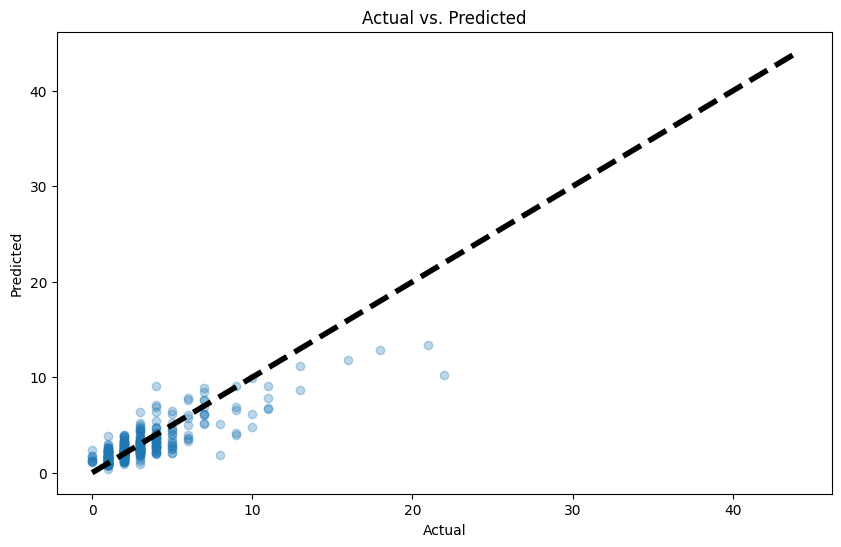

In [0]:
import matplotlib.pyplot as plt

# Plotting actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()


***Graphical Analysis***

Clustered Points: A closer look at the clustering of points can help identify patterns or biases in the model predictions. For instance, if higher values are consistently underpredicted or overpredicted, it might suggest a need for non-linear modeling or revisiting the feature engineering phase.

Outliers: Points that are significantly off from the line could be outliers in the data or instances where the model fails to capture the underlying pattern.

# 5. Demonstration of SparkML Knowledge

### SparkML Utilization:


Demonstrated the use of VectorAssembler for feature transformations suitable for ML algorithms in Spark.

Employed RegressionEvaluator for comprehensive evaluation across multiple metrics crucial for regression analysis.

### Advanced Features:

Could extend by implementing a Pipeline for streamlined processing and model evaluations.

Utilization of ParamGridBuilder and CrossValidator for robust hyperparameter tuning to optimize model parameters further, enhancing model performance and ensuring robustness against overfitting.

This detailed analysis and demonstration of SparkML not only show proficiency with the platform but also provide a deep understanding of how different models can be leveraged and optimized for specific types of data and business needs.

## Team Members and Contributions



*1. Manvith Katkuri*
  - Led data preprocessing and feature engineering
  - Implemented initial XGBoost model
  - Conducted feature importance analysis
  - Documentation and code review

*2. Purna Chandra Shekar Reddy Gosala*
  - Developed Spark ML pipeline implementation
  - Implemented cross-validation framework
  - Optimized model performance
  - Integration testing

*3. Shyam Rishi Sai Kalaparthy*
  - Set up Databricks environment
  - Handled data ingestion and cleaning
  - Implemented data quality checks
  - Performance optimization

*4. Ranjith Babu Vennam*
  - Project coordination and planning
  - Business requirements gathering
  - Results interpretation and presentation
  - Final report compilation